In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.init as init
from math import log10
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
from os import listdir
from os.path import join

In [10]:
#Data

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y

CROP_SIZE = 128

class DatasetFromFolder(Dataset):
    def __init__(self, image_dir, scale_factor, with_bicubic_upsampling = True):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        crop_size = CROP_SIZE - (CROP_SIZE % scale_factor) # Valid crop size
        
        if with_bicubic_upsampling:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor),  # subsampling the image (half size)
                                        transforms.Resize(crop_size, interpolation=Image.BICUBIC),  # bicubic upsampling to get back the original size 
                                        transforms.ToTensor()])
        else:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor),  # subsampling the image (half size)
                                        transforms.ToTensor()])

        self.target_transform = transforms.Compose([transforms.CenterCrop(crop_size), # since it's the target, we keep its original quality
                                       transforms.ToTensor()])

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        
        input = input.filter(ImageFilter.GaussianBlur(1)) 
        input = self.input_transform(input)
        target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)

In [11]:
#ESPCN Model

class ESPCN(nn.Module):
    def __init__(self, scale_factor):
        super(ESPCN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 1 * scale_factor**2, kernel_size=3, stride=1, padding=1)
        self.deconvolution = nn.PixelShuffle(scale_factor)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        out = self.tanh(self.conv1(x))
        out = self.tanh(self.conv2(out))
        out = self.deconvolution(self.conv3(out))
        return out

In [12]:
#Main

# Parameters
BATCH_SIZE = 4
NUM_WORKERS = 0 # on Windows, set this variable to 0
scale_factor = 4
nb_epochs = 15
cuda = True


device = torch.device("cuda:0" if (torch.cuda.is_available() and cuda) else "cpu")
torch.manual_seed(0)
torch.cuda.manual_seed(0)


trainset = DatasetFromFolder("data/train", scale_factor=scale_factor, with_bicubic_upsampling=False)
testset = DatasetFromFolder("data/test", scale_factor=scale_factor, with_bicubic_upsampling=False)

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = ESPCN(scale_factor=scale_factor).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)


hist_loss_train = []
hist_loss_test = []
hist_psnr_train = []
hist_psnr_test = []
for epoch in range(nb_epochs):

    # Train
    avg_psnr = 0
    epoch_loss = 0
    for iteration, batch in enumerate(trainloader):
        input, target = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()

        out = model(input)
        loss = criterion(out, target)
        psnr = 10 * log10(1 / loss.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        avg_psnr += psnr

    print(f"Epoch {epoch}. Training loss: {epoch_loss / len(trainloader)}")
    hist_loss_train.append(epoch_loss / len(trainloader))
    hist_psnr_train.append(avg_psnr / len(trainloader))

    # Test
    avg_psnr = 0
    epoch_loss = 0
    with torch.no_grad():
        for batch in testloader:
            input, target = batch[0].to(device), batch[1].to(device)

            out = model(input)
            loss = criterion(out, target)
            psnr = 10 * log10(1 / loss.item())
            epoch_loss += loss.item()
            avg_psnr += psnr

    print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")
    hist_loss_test.append(epoch_loss / len(testloader))
    hist_psnr_test.append(avg_psnr / len(testloader))

    # Save model
torch.save(model, f"model_{epoch}.pth")

Epoch 0. Training loss: 0.16158920956686848
Average PSNR: 18.250968514656215 dB.
Epoch 1. Training loss: 0.011171549979952119
Average PSNR: 20.495453982097107 dB.
Epoch 2. Training loss: 0.008642877736646268
Average PSNR: 21.049391947668866 dB.
Epoch 3. Training loss: 0.009234785782321104
Average PSNR: 21.37242810819121 dB.
Epoch 4. Training loss: 0.007226767694754969
Average PSNR: 21.775201066901623 dB.
Epoch 5. Training loss: 0.006853103896396028
Average PSNR: 22.051474928934457 dB.
Epoch 6. Training loss: 0.00689157626281182
Average PSNR: 21.315943426241397 dB.
Epoch 7. Training loss: 0.006573023422369881
Average PSNR: 22.32424721700441 dB.
Epoch 8. Training loss: 0.006058383016063581
Average PSNR: 22.463405450353648 dB.
Epoch 9. Training loss: 0.006348707432311679
Average PSNR: 18.687318803852808 dB.
Epoch 10. Training loss: 0.0069082555257611806
Average PSNR: 22.617808815597183 dB.
Epoch 11. Training loss: 0.0056559777345567466
Average PSNR: 22.785022548919947 dB.
Epoch 12. Traini

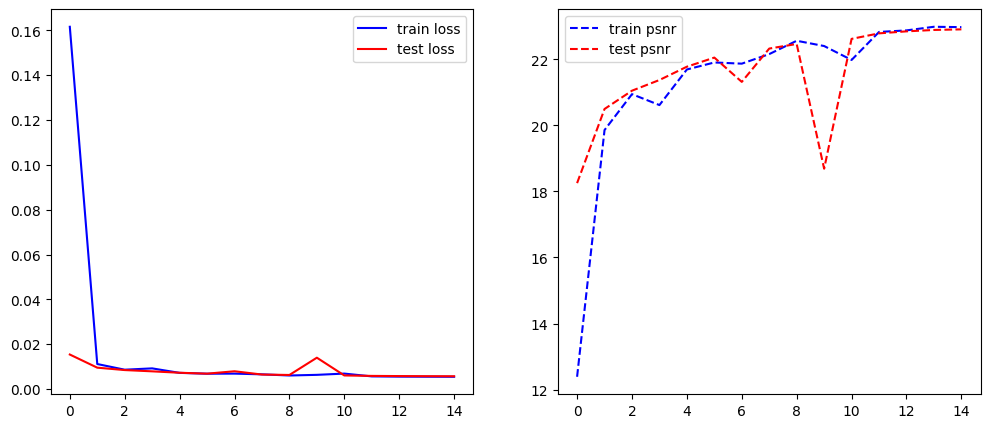

In [13]:
_, ax = plt.subplots(1,2)
ax[0].plot(hist_loss_train, label='train loss', c='b')
ax[0].plot(hist_loss_test, label='test loss', c='r')
ax[0].legend()
ax[1].plot(hist_psnr_train, label='train psnr', c='b', linestyle='--')
ax[1].plot(hist_psnr_test, label='test psnr', c='r', linestyle='--')
ax[1].legend()
_.set_size_inches(12,5)

/Users/adriensade/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  


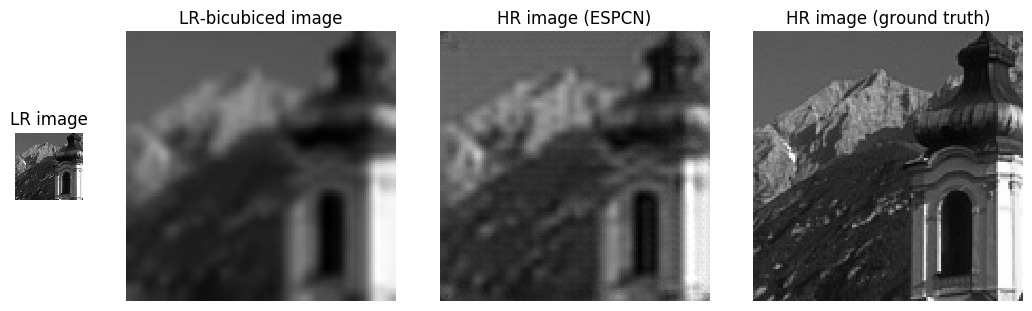

In [18]:
k = np.random.randint(0,13)
for idx, (test_features, test_labels) in enumerate(testloader):
    if idx != k: continue;
    crop_size = CROP_SIZE - (CROP_SIZE % scale_factor) # Valid crop size
    crop = transforms.CenterCrop(crop_size)
    bicubic_resize = transforms.Resize(crop_size, interpolation=Image.BICUBIC)

    LR_original = crop(test_labels[0]).squeeze()
    LR =  bicubic_resize(test_features[0]).squeeze()     #Low Resolution (bicubiced) image
    GT = test_labels[0].squeeze()      #Ground Truth
    HR = (model(test_features.to(device)).cpu().squeeze()[0].detach().numpy()*255.0).clip(0,255)        #High Resolution SRCNN image

    _, ax = plt.subplots(1,4, gridspec_kw={'width_ratios': [1, scale_factor, scale_factor, scale_factor]})
    ax[0].imshow(LR_original, cmap="gray")
    ax[1].imshow(LR, cmap="gray")
    ax[2].imshow(HR, cmap="gray")   
    ax[3].imshow(GT, cmap="gray")
    ax[0].title.set_text('LR image')
    ax[1].title.set_text('LR-bicubiced image')
    ax[2].title.set_text('HR image (ESPCN)')
    ax[3].title.set_text('HR image (ground truth)')

    _.set_size_inches(13,13)
    for i in range(4): ax[i].set_axis_off()
    plt.show()
    #print(f"Label: {label}")